# 1. Data Import and Analysis


In [1]:
%pip install --quiet gensim nltk optuna seaborn torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pickle
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
os.chdir("../../..")


In [4]:
from src.utils.visualization import plot_sentiment_distribution
from src.utils.preprocessing import preprocess_text

In [5]:
df = pd.read_csv(
    'dataset/processed/combined_sentiment_dataset.csv', 
    encoding='utf-8'
)
df.head()

,Sentences,Sentiment
0,पुन निर्वाचन गरे यस्तै हुने हो निर्वाचन कति गर...,0
1,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे,0
2,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...,0
3,कपिलवस्तुको शिवराज नगरपालिका का बासिन्दाले पाए...,0
4,कपिलवस्तुको शिवराज नगरपालिका का बासिन्दाले वर्...,0


In [6]:
df.shape

(40708, 2)

Remove the neutral data


In [7]:
df = df[df['Sentiment'] != 0]
df = df.reset_index(drop=True)

In [8]:
# replace the label 2: negative with 0 for neg
df['Sentiment'] = df['Sentiment'].replace(2, 0)
df['Sentiment'].value_counts()

Sentiment
1    15857
0    14393
Name: count, dtype: int64

In [10]:
labels_dict = {
    0: 'Negative',
    1: 'Positive', 
}

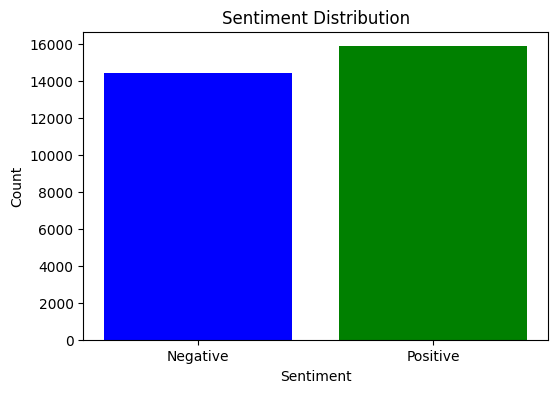

In [11]:
plot_sentiment_distribution(
    df, 
    'Sentiment Distribution', 
    labels_dict
)

### Length of the reviews


In [12]:
def print_len(data):
    total_len = 0
    pos_len = 0
    neg_len = 0
    for index, row in data.iterrows():
        l = len(row['Sentences'].split(' '))
        total_len += l
        if row['Sentiment'] == 0:
            pos_len += l
        else:
            neg_len += l

    print('Average length of Sentence : ' +
          str(total_len/len(data['Sentences'])))
    print('Average length of positive Sentence : ' +
          str(pos_len/df['Sentiment'].value_counts()[1]))
    print('Average length of negative Sentence : ' +
          str(neg_len/df['Sentiment'].value_counts()[0]))


print_len(df)

Average length of Sentence : 16.58899173553719
Average length of positive Sentence : 14.492463896071136
Average length of negative Sentence : 18.89877023553116


In [13]:
# maximum length of sentence from the column 'Sentences' using numpy or pandas
max_len = df['Sentences'].apply(lambda x: len(x.split(' '))).max()
max_len

58

### Missing and Duplicated values


In [14]:
df.isna().sum()

Sentences    0
Sentiment    0
dtype: int64

In [15]:
df.duplicated().sum()

100

In [16]:
df = df.drop_duplicates()

# 3. Text Understanding


In [17]:
from collections import Counter

positive_reviews = df[df['Sentiment'] == 1]['Sentences']
negative_reviews = df[df['Sentiment'] == 0]['Sentences']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

positive_word_freq = Counter(positive_text.split(' '))
negative_word_freq = Counter(negative_text.split(' '))

# Create a list to store the frequency differences
word_diff = {}

# Calculate the frequency difference for each word
all_words = set(positive_word_freq.keys()).union(
    set(negative_word_freq.keys()))
for word in all_words:
    pos_freq = positive_word_freq.get(word, 0)
    neg_freq = negative_word_freq.get(word, 0)
    word_diff[word] = abs(pos_freq - neg_freq)

# Separate positive and negative words based on frequency difference
positive_words_diff = {}
negative_words_diff = {}

# Classify words based on where they are more frequent
for word, diff in word_diff.items():
    if positive_word_freq.get(word, 0) > negative_word_freq.get(word, 0):
        positive_words_diff[word] = diff
    elif negative_word_freq.get(word, 0) > positive_word_freq.get(word, 0):
        negative_words_diff[word] = diff

# Sort the words by frequency difference (descending)
sorted_positive_words = sorted(
    positive_words_diff.items(), key=lambda x: x[1], reverse=True)
sorted_negative_words = sorted(
    negative_words_diff.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 words for both positive and negative categories
print("Top 20 Positive Words:")
for word, diff in sorted_positive_words[:20]:
    print(word)

print("----------------\nTop 20 Negative Words:")
for word, diff in sorted_negative_words[:20]:
    print(word)

Top 20 Positive Words:
लागि
कोभिड
तथा
गर्न
गर्ने
गरेको
सहयोग
खोप
रोकथाम
परीक्षण
सरकारले
शुभकामना
विरुद्धको
विरुद्ध
नेपाली
नेपाल
निर्णय
नियन्त्रण
हार्दिक
स्वास्थ्य
----------------
Top 20 Negative Words:
मृत्यु
संख्या
पुष्टि
संक्रमण
जनामा
भएको
हजार
संक्रमित
जना
कोरोना
थप
भाइरस
नेपालमा
संक्रमितको
लाख
पुगेको
एक
जनाको
सय
कारण


# LSTM Model


In [18]:
sentences = [item for item in df['Sentences']]
sentiments = [item for item in df['Sentiment']]

In [19]:
from src.utils.preprocessing import tokenizer
tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]

In [20]:
import numpy as np

sentence_lengths = [len(tokens) for tokens in tokenized_sentences]  # List of sentence lengths
percentile_90 = np.percentile(sentence_lengths, 90)
print(f"90th percentile sentence length: {percentile_90}")

90th percentile sentence length: 32.0


In [21]:
from gensim.models import KeyedVectors

embedding_model_file = 'src/models/word2vec_model.bin'
word2vec_model = KeyedVectors.load_word2vec_format(embedding_model_file, binary=True)

In [22]:
# Convert each token to its word2vec embedding
max_length = 32

embedded_reviews = []

for tokens in tokenized_sentences:
    review_vector = []
    for token in tokens:
        if token in word2vec_model:
            review_vector.append(word2vec_model[token])
        else:
            # If token not found, use a zero vector
            review_vector.append(np.zeros(word2vec_model.vector_size))

    # Pad the review to max_length with zero vectors
    if len(review_vector) > max_length:
        review_vector = review_vector[:max_length]
    else:
        review_vector.extend(
            [np.zeros(word2vec_model.vector_size)] * (max_length - len(review_vector)))

    embedded_reviews.append(review_vector)

In [23]:
embedded_reviews_array = np.array(embedded_reviews)
embedded_reviews_array.shape

(30150, 32, 300)

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [25]:
# Shape: (30150, 32, 300)
X = torch.tensor(embedded_reviews_array, dtype=torch.float32)
y = torch.tensor(sentiments, dtype=torch.long)  # Shape: (30150,)

print(f"Shape of X: {X.shape}")

Shape of X: torch.Size([30150, 32, 300])


Split the dataset into Training, Validation, and Test sets.


In [26]:
# First, split into training and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

In [27]:
# Then, split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, random_state=42
)

In [28]:
# Convert to DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

In [29]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [30]:
from src.models.lstm_binary import LSTMBinaryModel

In [31]:
# Model parameters
input_dim = 300     # Embedding dimension
hidden_dim = 128    # Number of LSTM units
output_dim = 1      # Number of classes (0 or 1)
num_layers = 2      # Number of LSTM layers

In [32]:
# Instantiate the model, loss function, and optimizer
model = LSTMBinaryModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [34]:
model = model.to(device)

In [35]:
# Early stopping parameters
patience = 10  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [42]:
for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure labels are of shape (batch_size,)
        labels = labels.unsqueeze(1).float()  # Add an extra dimension and cast to float
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        
        # Threshold the logits for binary classification
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Threshold at 0.5
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = running_loss / len(train_loader)  # Average training loss
    train_accuracy = 100 * correct_predictions / total_predictions

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            labels = labels.float()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Threshold the logits for binary classification
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Threshold at 0.5
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)

            # Store true and predicted labels for confusion matrix
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)  # Average validation loss
    val_accuracy = 100 * correct_val_predictions / total_val_predictions

    # Append metrics to lists for tracking
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping and learning rate scheduling
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        print("Best validation loss so far")
    else:
        epochs_without_improvement += 1
        print(f"{epochs_without_improvement}/{patience} epochs without improvement")

    if epochs_without_improvement >= patience:  # Early stopping condition
        print("Early stopping triggered.")
        break

ValueError: Target size (torch.Size([64])) must be the same as input size (torch.Size([64, 1]))

In [ ]:
output_file = "src/models/outputs/lstm_binary_model.pth"
        torch.save(model.state_dict(), output_file)
        print(f"Model saved to {output_file}")

In [ ]:
# Training and evaluation function
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = len(loader.dataset)
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # For multiclass
            all_labels.extend(labels.view(-1).cpu().numpy())
            all_predictions.extend(predicted.view(-1).cpu().numpy())
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, precision, recall

In [ ]:
# Load best model for final evaluation
model.load_state_dict(
    torch.load(
        output_file,
        map_location=torch.device('cpu'),
        weights_only=True
    )
)

# Evaluate on test set
test_accuracy, test_f1, test_precision, test_recall = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1 Score: {test_f1:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Neutral', 'Positive', 'Negative']))

In [ ]:
# Load the model
model = LSTMBinaryModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
model.load_state_dict(torch.load(output_file))
model.eval()

sentences = ["यो फोन खराब छ", "म यो फोन राम्रो पाए", "यो फोन राम्रो छ"]
max_length = 20
for sentence in sentences:
    sentence = preprocess_text(sentence)
    tokens = tokenizer.tokenize(sentence)
    review_vector = []
    for token in tokens:
        if token in word2vec_model:
            review_vector.append(word2vec_model[token])
        else:
            review_vector.append(np.zeros(word2vec_model.vector_size))

    # Pad the review to max_length with zero vectors
    if len(review_vector) > max_length:
        review_vector = review_vector[:max_length]
    else:
        review_vector.extend([np.zeros(word2vec_model.vector_size)] * (max_length - len(review_vector)))

    review_vector = torch.tensor(review_vector, dtype=torch.float32).unsqueeze(0).to(device)
    output = model(review_vector)
    probability = torch.sigmoid(output).item()
    predicted = (probability > 0.5)

    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {labels_dict[int(predicted)]}")
    print(f"Confidence: {probability:.2f}")